In [10]:
# some form of layer-wise learning

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [5]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [159]:
def gen_test_data():
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100s0)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, 0.1, size=x.shape)

    return x, y + noise

x, y = gen_test_data()


In [160]:
plt.figure()
plt.plot(x, y)
plt.show()
plt.close()

In [161]:
x.shape

(1000, 1)

In [162]:
y.shape

(1000, 1)

In [163]:
y.T.shape

(1, 1000)

# TYPE 1: network type: input.shape = 1, output.shape = y.shape[1]

In [164]:
def build_model_linear(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='linear')(output_1)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    model = tf.keras.Model(input_layer, output_2)
    
    return model

In [165]:
def build_model_nonlinear(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='relu', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='relu')(output_1)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)
    
    
    model = tf.keras.Model(input_layer, output_2)
    
    return model

In [166]:
def build_submodel_linear(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    final_output = tf.keras.layers.Add()([output_1, output_2])
    
    model = tf.keras.Model(input_layer, final_output)
    
    return model

In [167]:
def build_submodel_nonlinear(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)
    
    final_output = tf.keras.layers.Add()([output_1, output_2])
    
    model = tf.keras.Model(input_layer, final_output)
    
    return model

In [168]:
def build_submodel_subnetwork(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    final_output = tf.keras.layers.Add()([output_1, output_2])
    
    model = tf.keras.Model(input_layer, final_output)
    
    return model

In [169]:
type1_data = {
    'x':np.array([[0]]),
    'y':y.T
}

In [178]:
%%time

# model_type1 = build_submodel_subnetwork(input_shape=type1_data['x'].shape[1], output_shape=type1_data['y'].shape[1])
# model_type1 = build_submodel_linear(input_shape=type1_data['x'].shape[1], output_shape=type1_data['y'].shape[1])
# model_type1 = build_submodel_nonlinear(input_shape=type1_data['x'].shape[1], output_shape=type1_data['y'].shape[1])


model_type1 = build_model_linear(input_shape=type1_data['x'].shape[1], output_shape=type1_data['y'].shape[1])
# model_type1 = build_model_nonlinear(input_shape=type1_data['x'].shape[1], output_shape=type1_data['y'].shape[1])


lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)

model_type1.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_type1 = model_type1.fit(type1_data['x'], type1_data['y'], epochs=500, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

CPU times: user 2.07 s, sys: 312 ms, total: 2.38 s
Wall time: 1.26 s


In [179]:
model_type1.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_148 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_149 (Dense)            (None, 128)               16512     
_________________________________________________________________
output_1 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dense_150 (Dense)            (None, 128)               128128    
_________________________________________________________________
dense_151 (Dense)            (None, 128)               16512     
_________________________________________________________________
output_2 (Dense)             (None, 1000)              129

In [180]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(history_type1.history['loss'], label='loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [181]:
yhat1 = model_type1.predict(type1_data['x'])[0]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(x, type1_data['y'][0])
plt.plot(x, yhat1, ls='--')
# plt.xlim(-0.1,0.1)

plt.subplot(2, 1, 2)
plt.plot(x, type1_data['y'][0]-yhat1)


# TYPE 2: network type: input.shape = 1, output.shape = 1

In [213]:
def type_2_build_model_linear(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    x = tf.keras.layers.Dense(1000, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    x = tf.keras.layers.Dense(1000, activation='linear')(output_1)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    x = tf.keras.layers.Dense(1000, activation='linear')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    model = tf.keras.Model(input_layer, output_2)
    
    return model

In [214]:
def type_2_build_model_nonlinear(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='relu', name='output_1')(x)
    
    x = tf.keras.layers.Dense(1000, activation='relu')(output_1)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    model = tf.keras.Model(input_layer, output_2)
    
    return model

In [215]:
def type_2_build_submodel_subnetwork(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    x = tf.keras.layers.Dense(1000, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    final_output = tf.keras.layers.Add()([output_1, output_2])
    
    model = tf.keras.Model(input_layer, final_output)
    
    return model

In [216]:
def type_2_build_submodel_subnetwork_resnet(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    x = tf.keras.layers.Dense(1000, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)

    final_output = tf.keras.layers.Add()([output_1, output_2])
    
    final_output = tf.keras.layers.Add()([input_layer, final_output])
    
    model = tf.keras.Model(input_layer, final_output)
    
    return model

In [217]:
type2_data = {
    'x':x,
    'y':y
}

In [218]:
type2_data['x'].shape[1]

1

In [219]:
type2_data['y'].shape[1]

1

In [220]:
%%time

# model_type2 = type_2_build_model_linear(input_shape=type2_data['x'].shape[1], output_shape=type2_data['y'].shape[1])
model_type2 = type_2_build_model_nonlinear(input_shape=type2_data['x'].shape[1], output_shape=type2_data['y'].shape[1])

# model_type2 = type_2_build_submodel_subnetwork(input_shape=type2_data['x'].shape[1], output_shape=type2_data['y'].shape[1])
# model_type2 = type_2_build_submodel_subnetwork_resnet(input_shape=type2_data['x'].shape[1], output_shape=type2_data['y'].shape[1])


lr = 1e-3

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)

model_type2.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_type2 = model_type2.fit(type2_data['x'], type2_data['y'], epochs=5000, verbose=0, callbacks=callbacks, batch_size=500)

Training:   0%|           0/5000 ETA: ?s,  ?epochs/s

CPU times: user 6min 47s, sys: 1min 14s, total: 8min 2s
Wall time: 1min 45s


In [222]:
model_type2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_198 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_199 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_200 (Dense)            (None, 1000)              129000    
_________________________________________________________________
output_1 (Dense)             (None, 1)                 1001      
_________________________________________________________________
dense_201 (Dense)            (None, 1000)              2000      
_________________________________________________________________
dense_202 (Dense)            (None, 128)               128

In [223]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(history_type2.history['loss'], label='loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')

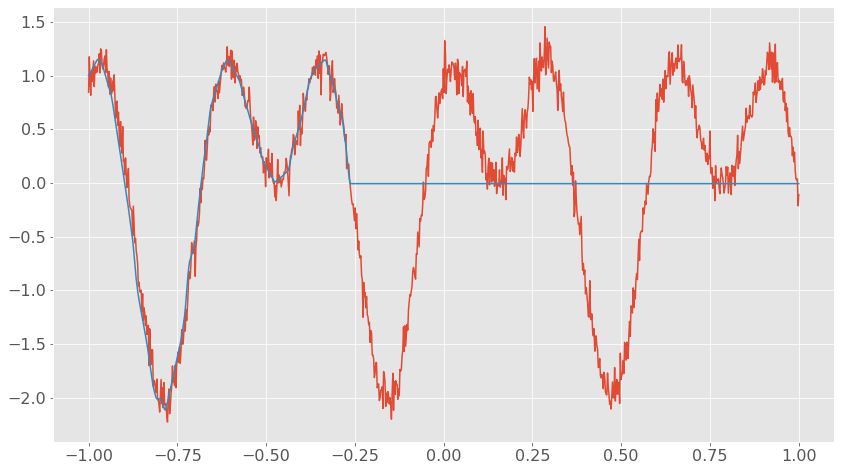

In [224]:
plt.figure(figsize=(14, 8))
plt.plot(type2_data['x'], type2_data['y'])
plt.plot(type2_data['x'], model_type2.predict(type2_data['x']))

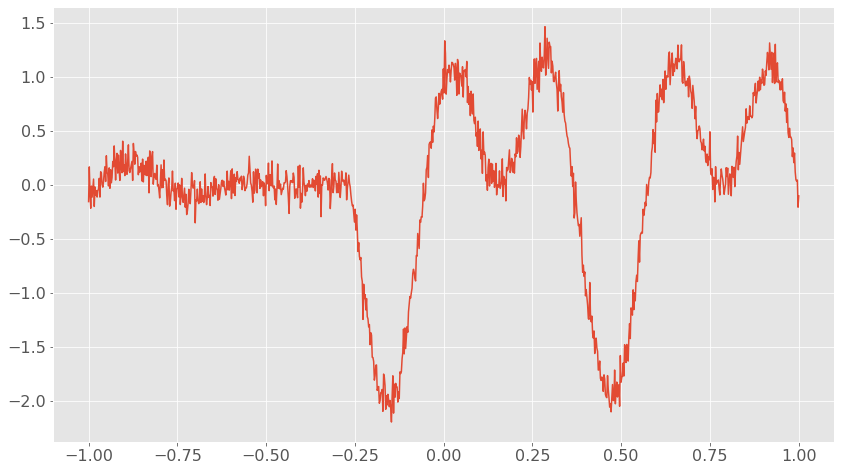

In [225]:
plt.figure(figsize=(14, 8))
plt.plot(type2_data['x'], type2_data['y']-model_type2.predict(type2_data['x']))